In [6]:
'''Trains a simple convnet on the MNIST dataset.

Gets to 99.25% test accuracy after 12 epochs
(there is still a lot of margin for parameter tuning).
16 seconds per epoch on a GRID K520 GPU.
'''

# from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

#from keras.optimizers import gradient_descent_v2
#from keras.utils import np_utils
import tensorflow as tf


batch_size = 16
num_classes = 10
epochs = 5

# input image dimensions
img_rows, img_cols = 28, 28

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

print(input_shape)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(keras.layers.RandomRotation((-0.05,0.05), fill_mode="nearest"))
model.add(keras.layers.GaussianNoise(0.1))
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

sch = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-2,
                                                  decay_steps=10000,
                                                  decay_rate=0.9)

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.SGD(learning_rate=sch),
              metrics=['accuracy','Recall','Precision'])

from keras.callbacks import TensorBoard, EarlyStopping
TB = TensorBoard(log_dir='./logs')
ES = EarlyStopping(monitor="val_accuracy", patience=0, restore_best_weights=True)

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test),
          callbacks=[TB, ES])
score = model.evaluate(x_test, y_test, verbose=0)

model.save('my_model.keras')
del model

from keras.models import load_model
model = load_model('my_model.keras')

print('Test loss:', score[0])
print('Test accuracy:', score[1])

(28, 28, 1)
x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Epoch 1/5


3750/3750 ━━━━━━━━━━━━━━━━━━━━ 60s 16ms/step - Precision: 0.8360 - Recall: 0.5776 - accuracy: 0.6903 - loss: 0.9299 - val_Precision: 0.9642 - val_Recall: 0.9389 - val_accuracy: 0.9512 - val_loss: 0.1656
Epoch 2/5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 58s 16ms/step - Precision: 0.9289 - Recall: 0.8801 - accuracy: 0.9039 - loss: 0.3163 - val_Precision: 0.9759 - val_Recall: 0.9644 - val_accuracy: 0.9697 - val_loss: 0.0912
Epoch 3/5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 59s 16ms/step - Precision: 0.9529 - Recall: 0.9259 - accuracy: 0.9395 - loss: 0.2053 - val_Precision: 0.9817 - val_Recall: 0.9768 - val_accuracy: 0.9791 - val_loss: 0.0631
Epoch 4/5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 59s 16ms/step - Precision: 0.9613 - Recall: 0.9433 - accuracy: 0.9516 - loss: 0.1582 - val_Precision: 0.9861 - val_Recall: 0.9818 - val_accuracy: 0.9839 - val_loss: 0.0502
Epoch 5/5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 58s 16ms/step - Precision: 0.9678 - Recall: 0.9529 - accuracy: 0.9598 - loss: 0.1358 - val_Precision: 0.9880 - val_Re

This Python code is using the Keras library to build a Convolutional Neural Network (CNN) model for image classification. The model is built using the Sequential API, which allows you to stack layers on top of each other in a linear manner.

1. `model = Sequential()`: This line initializes a new Sequential model. 

2. `model.add(keras.layers.RandomRotation((-0.05,0.05), fill_mode="nearest"))`: This line adds a layer that applies a random rotation to the input images. The rotation will be a random value between -0.05 and 0.05 radians. The `fill_mode` parameter is set to "nearest", which means that any points outside the input image will be filled according to the nearest pixel.

3. `model.add(keras.layers.GaussianNoise(0.1))`: This line adds a layer that applies Gaussian noise to the input images. This can help to prevent overfitting by providing a form of data augmentation.

4. `model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))`: This line adds a 2D convolution layer to the model. The layer will have 32 output filters, each with a size of 3x3. The activation function is set to 'relu', which stands for Rectified Linear Unit. The `input_shape` parameter specifies the shape of the input data.

5. `model.add(Conv2D(64, (3, 3), activation='relu'))`: This line adds another 2D convolution layer, this time with 64 output filters.

6. `model.add(MaxPooling2D(pool_size=(2, 2)))`: This line adds a max pooling layer, which reduces the spatial dimensions of the input. The pool size is set to 2x2.

7. `model.add(Dropout(0.25))`: This line adds a dropout layer, which randomly sets a fraction (25% in this case) of the input units to 0 at each update during training. This helps to prevent overfitting.

8. `model.add(Flatten())`: This line adds a layer that flattens the input. This is necessary because after the convolution and pooling layers, the data is still in a 2D format, but the following dense layers expect input in a 1D format.

9. `model.add(Dense(128, activation='relu'))`: This line adds a dense (fully connected) layer with 128 units to the model. The activation function is again set to 'relu'.

10. `model.add(Dropout(0.5))`: This line adds another dropout layer, this time dropping out 50% of the input units.

11. `model.add(Dense(num_classes, activation='softmax'))`: This line adds the final dense layer, which has a number of units equal to the number of classes in the classification problem. The activation function is set to 'softmax', which is commonly used in multi-class classification problems to output a probability distribution over the classes.

In [ ]:
#\ ! tensorboard --logdir="./logs"   ## for visualization on your own computer

In [7]:
model.summary()

import tensorflow as tf
from tensorflow import keras
#keras.utils.plot_model(model, "my_first_model_with_shape_info.png", show_shapes=True)

#model.weights
#model.weights[0]
#model.weights[0][1][1][0][4]

#print(model.layers)
#print(model.layers[0])
#print(model.layers[7].weights)
#print(model.layers[7].get_weights())
print(model.layers[7].get_weights()[0][0][0])


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_rotation_2               │ (16, 28, 28, 1)        │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_noise_2                │ (16, 28, 28, 1)        │             0 │
│ (GaussianNoise)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (16, 26, 26, 32)       │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (16, 24, 24, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (16, 12, 12, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (16, 12, 12, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (16, 9216)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (16, 128)              │     1,179,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (16, 128)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (16, 10)               │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,199,883 (4.58 MB)

 Trainable params: 1,199,882 (4.58 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1 (8.00 B)

0.005378517


 41/313 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
(10000, 10)


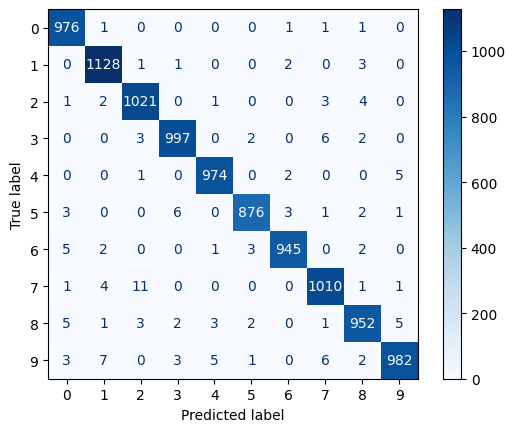

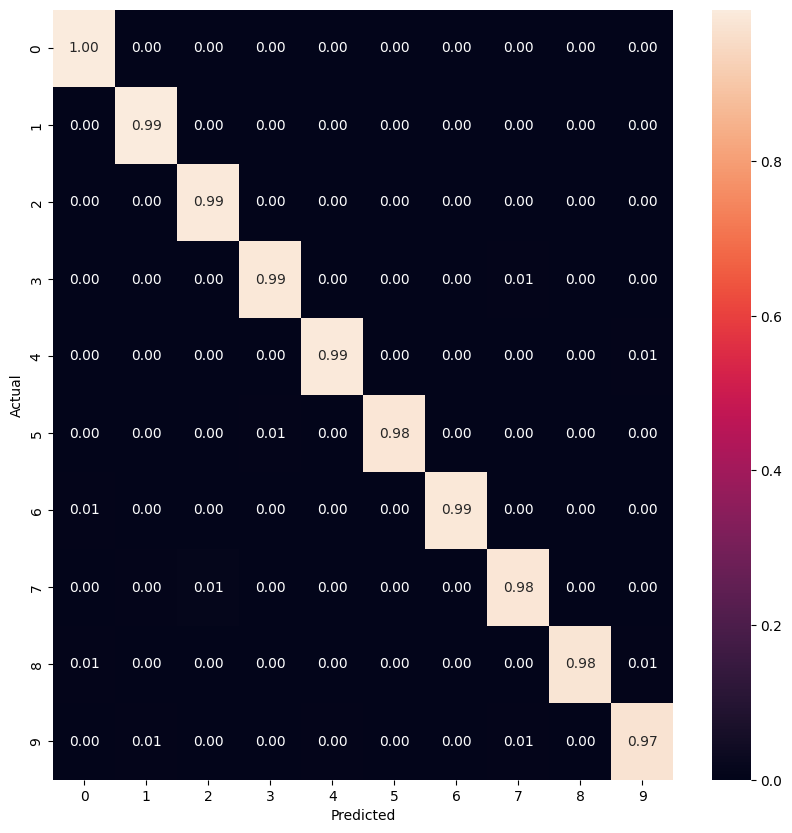

In [8]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

y_pred = model.predict(x_test)
print(y_test.shape)
y_pred_plot=np.argmax(y_pred, axis=1)
y_test_plot=np.argmax(y_test, axis=1)

cm = confusion_matrix(y_test_plot, y_pred_plot)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
#disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

disp.plot(cmap=plt.cm.Blues)
plt.show()

import seaborn as sns
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)
